In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0 #(average of zero)
lst_dct = {col:[] for col in cols}
sigma = 5  #(standard deviation of 5)

In [2]:
lst_dct = {col:[] for col in cols}
for i in range(length):
    lst_dct["P"].append(25 + np.random.normal(mu, .5 * sigma))
    lst_dct["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1]  + np.random.normal(mu, sigma ))
    lst_dct["Y"].append(lst_dct["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 +  1.5 * lst_dct["X"][-1] -  lst_dct["Y"][-1] * 2 +  np.random.normal(mu,  sigma))
df = pd.DataFrame(lst_dct)
keys = cols 
df

,P,Q,X,Y,Z
0,26.324567,50.006227,151.616410,-43.118090,352.156970
1,24.085996,46.125184,139.229372,-37.290262,336.238739
2,23.865162,53.991415,163.133308,-55.444202,404.335739
3,20.616211,49.961185,144.328912,-47.270207,350.809311
4,20.895684,50.436637,155.170948,-45.652798,357.025478
...,...,...,...,...,...
9995,24.175280,52.654367,159.318488,-62.665629,418.203833
9996,27.041636,39.700675,118.727831,-39.773003,312.940285
9997,28.003578,49.479574,139.546229,-44.056573,346.990123
9998,24.776647,48.819291,144.533728,-48.005490,360.998634


<AxesSubplot:xlabel='Q', ylabel='Z'>

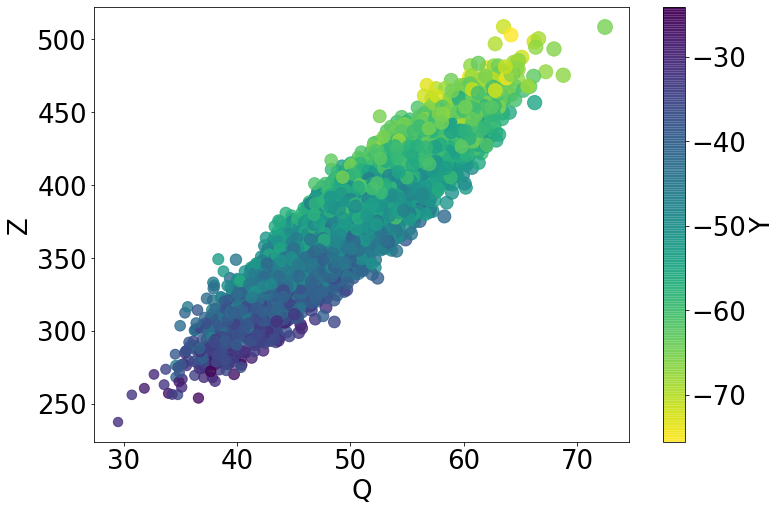

In [3]:
plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (12,8))
df.plot.scatter(x = "Q", y = "Z", c = "Y",s = "X", cmap = "viridis_r",alpha = .8, ax = ax)

In [4]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,0.013396,0.008974,-0.003268,0.150559
Q,0.013396,1.000000,0.950164,-0.708209,0.917331
X,0.008974,0.950164,1.000000,-0.671100,0.934926
Y,-0.003268,-0.708209,-0.671100,1.000000,-0.844742
Z,0.150559,0.917331,0.934926,-0.844742,1.000000


In [5]:
import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [6]:
residuals

,P,Q,X,Y,Z
0,4.199408,0.192197,7.026178,-4.265491,-14.131436
1,-1.678756,0.192910,-1.937512,3.671519,4.802749
2,-0.810537,-0.100677,-0.072767,0.068823,0.939843
3,-1.818987,1.777760,-1.112064,-0.001368,-1.387797
4,0.184895,-0.535049,5.181578,-2.500861,-8.676727
...,...,...,...,...,...
9995,-1.761393,-1.074938,-2.029985,0.128816,5.385646
9996,0.685196,-0.898098,-0.630333,0.498633,1.297525
9997,3.073642,2.829376,0.280970,-1.534026,-6.562080
9998,0.223734,0.469684,0.059089,-0.392447,-1.380673


In [7]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,0.01,-0.60,0.64,0.72
Q,0.01,1.00,0.50,-0.13,0.01
X,-0.60,0.50,1.00,0.74,0.83
Y,0.64,-0.13,0.74,1.00,-0.89
Z,0.72,0.01,0.83,-0.89,1.00


In [8]:
import pingouin
df.corr().round(2)

,P,Q,X,Y,Z
P,1.00,0.01,0.01,-0.00,0.15
Q,0.01,1.00,0.95,-0.71,0.92
X,0.01,0.95,1.00,-0.67,0.93
Y,-0.00,-0.71,-0.67,1.00,-0.84
Z,0.15,0.92,0.93,-0.84,1.00


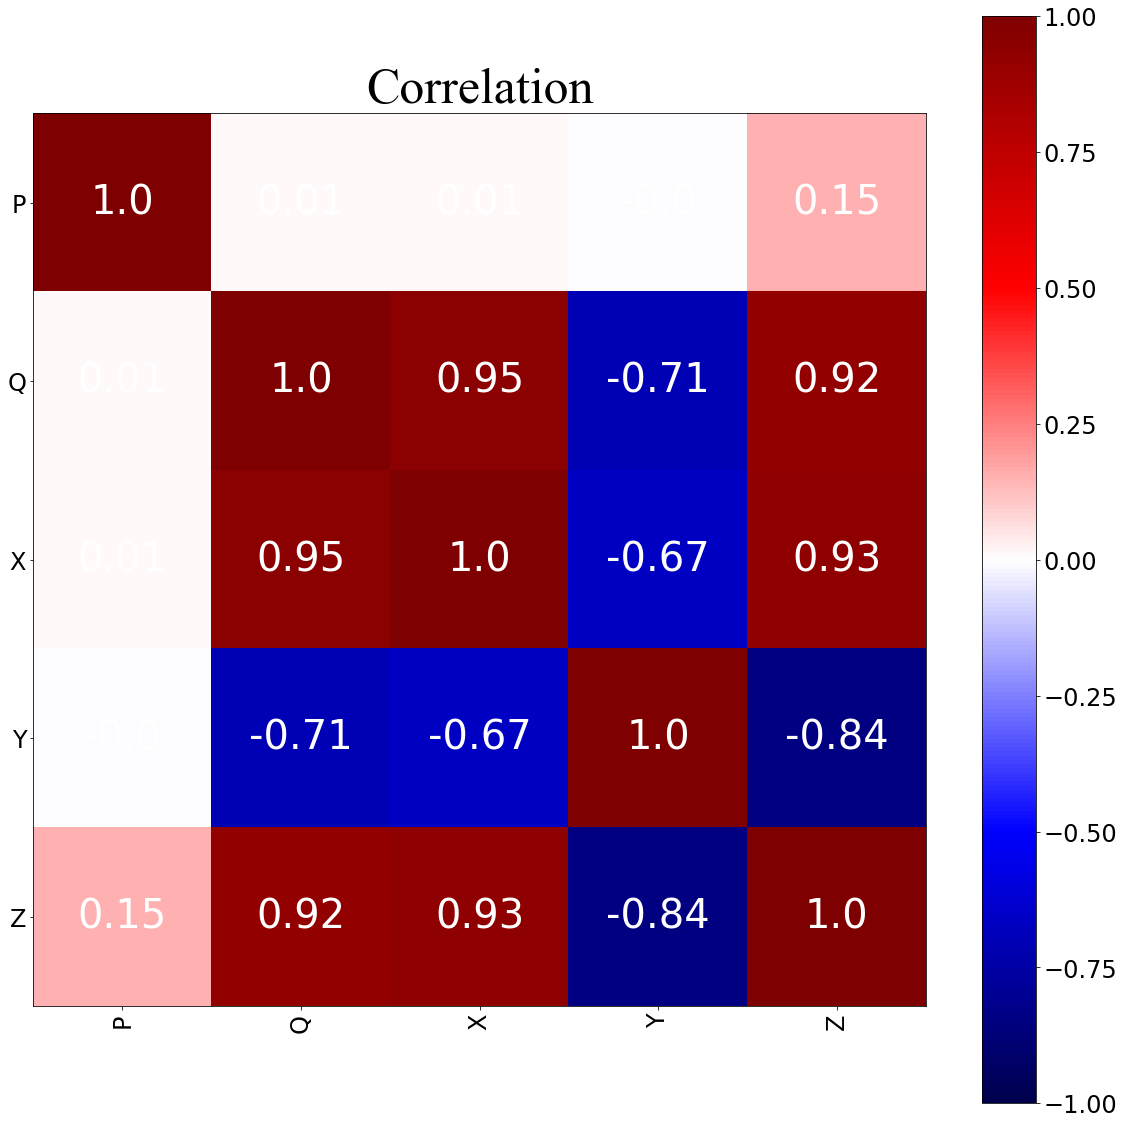

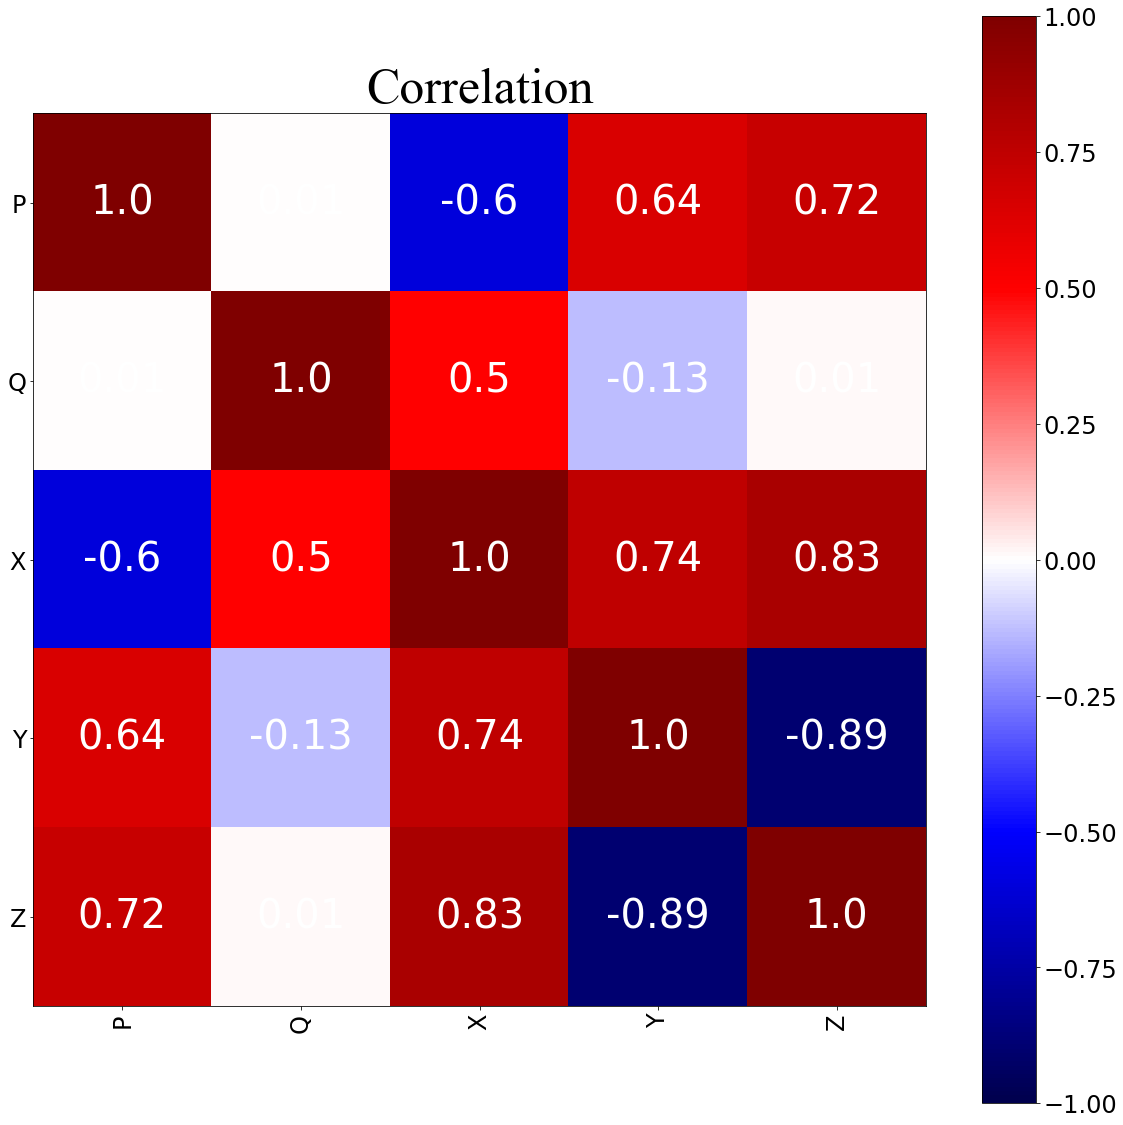

In [9]:
from datlib.plots import *
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None, 
                    #title = "Correlation"
                   )

corr_matrix_heatmap(df.pcorr(), 
                    save_fig = False, 
                    pp = None, 
                    #title = "Partial Correlation"
                   )

In [10]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            # this will regress one residual on the other, save the pvalue for the explanatory variable
            # and create a pvalue partial correlation
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

,P,Q,X,Y,Z
P,NaN,0.54,0.0,0.0,0.00
Q,0.54,NaN,0.0,0.0,0.39
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.39,0.0,0.0,NaN


In [11]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x] = [y for y in df.keys() if y != x]
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [12]:
import copy
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables 
                #  uses them as controls statistical significance holds without them,
                #  otherwise break
                #print(sorted(list(set(c_used))))
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)

    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x !=y:
                test = df.partial_corr(x=x,
                                      y=y,
                                      covar=None,
                                      method="pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z !=y and z !=x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

print(build_skeleton(df, undirected_graph))

{'P': ['Z'], 'Q': ['X', 'Y'], 'X': ['Q', 'Z'], 'Y': ['Q', 'Z'], 'Z': ['P', 'X', 'Y']}


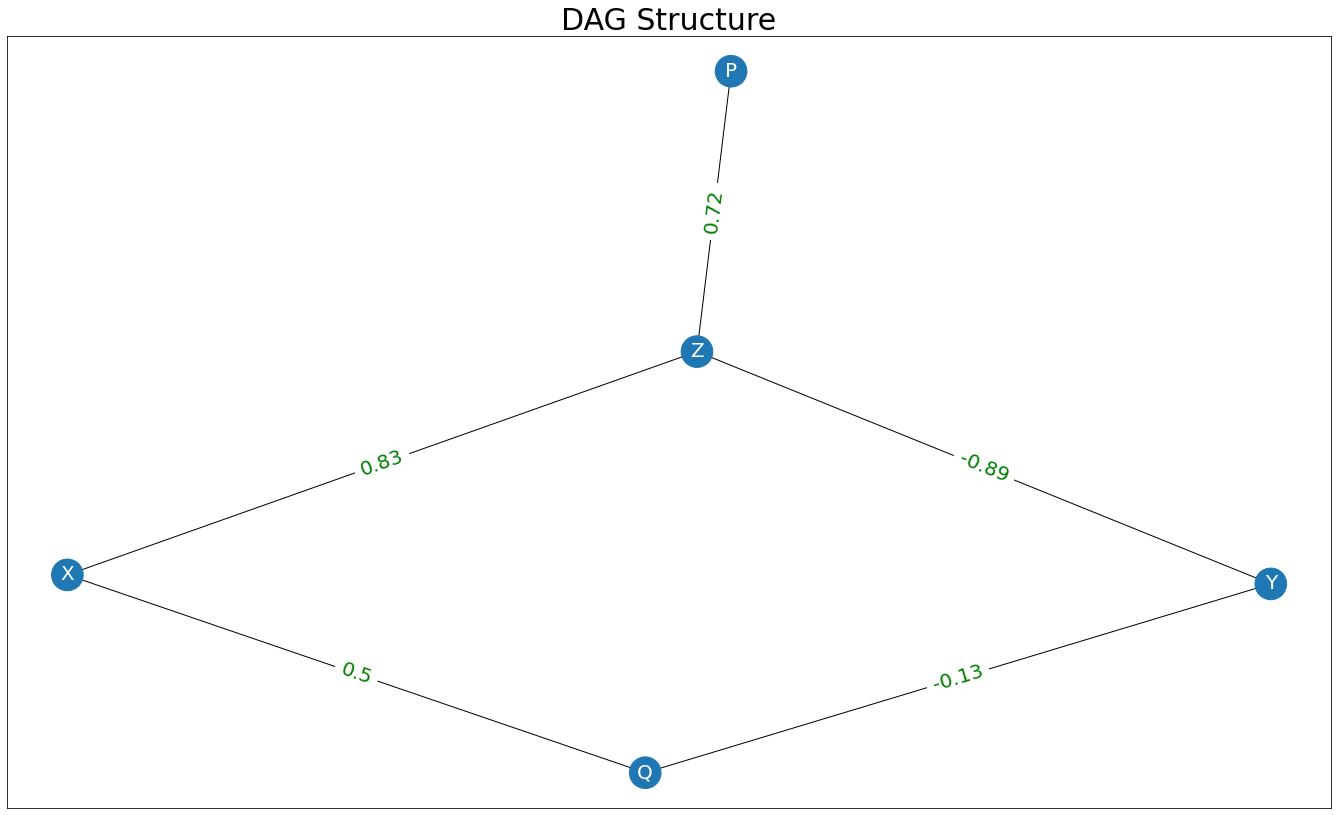

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph()
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2, key) not in edges:
                edge = (key.replace(" ","\n"), key2[0].replace(" ","\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
    
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    
    fix, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layouut(graph)
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 1000,
                     with_labels=True,  
                     arrows=False,
                     font_size = 20, 
                     alpha = 1,
                     font_color = "white",
                     ax = ax)
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    
    
    plt.show()
    
graph_DAG(undirected_graph, df)

In [14]:
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2
model = c.estimate(return_type = "dag",
                   variant= "parallel",    #"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, 
                   ci_test = "pearsonr")
edges = model.edges()
edges

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('P', 'Z'), ('Y', 'Z'), ('X', 'Z'), ('Q', 'Y'), ('Q', 'X')])

keep control: X
('P', 'Z') ['X']
('P', 'Z') ['X']
keep control: Y
('P', 'Z') ['X', 'Y']
keep control: X
('Y', 'Z') ['X']
('Y', 'Z') ['X']
keep control: P
('Y', 'Z') ['X', 'P']
keep control: Y
('X', 'Z') ['Y']
('X', 'Z') ['Y']
keep control: P
('X', 'Z') ['Y', 'P']
('Q', 'Y') []
('Q', 'Y') []
('Q', 'Y') []
('Q', 'X') []
('Q', 'X') []
('Q', 'X') []


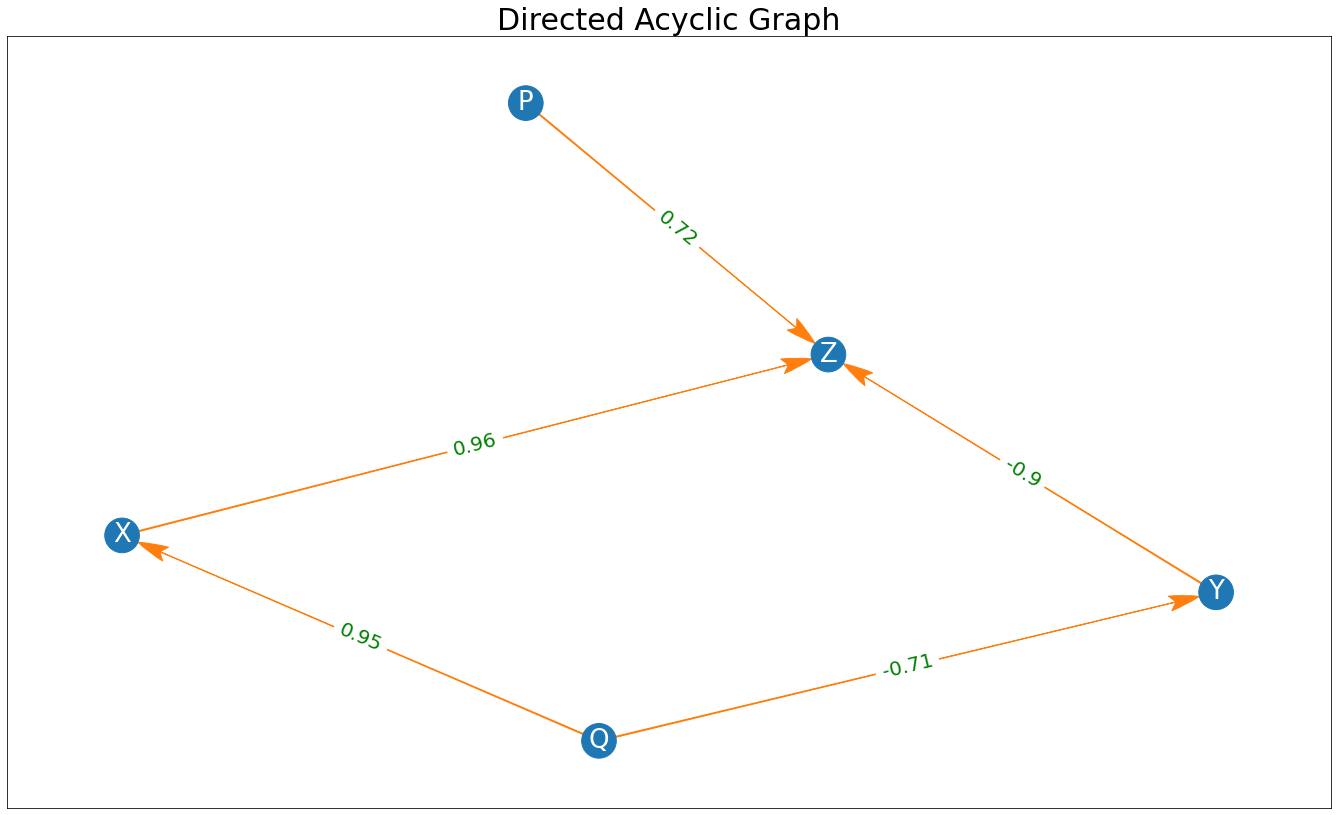

In [15]:
from matplotlib.patches import ArrowStyle
def graph_DAG(edges, df, title=""):
    graph = nx.DiGraph()
    
    edge_labels ={}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)
            print(edge, keep_controls)
            
            #build pcorr matrix with nodes from the edges + controls
            
            pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
            
            #edge_labels[edge] = str(pcorr.loc[edge[0]], edge[0])
            
            edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    
    
    graph.add_edges_from(edges)
    color_map =["C0" for g in graph]
    
    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, 
                     pos, 
                     node_color=color_map, 
                     node_size = 1200,
                     font_color = "white",
                     font_size = 26, 
                     alpha = 1,
                     width = 1, 
                     edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    
    nx.draw_networkx_edge_labels(graph,
                                 pos,
                                 edge_labels = edge_labels,
                                 font_color = "green",
                                 font_size = 20)
    
    plt.show()
graph_DAG(edges, df, title = "Directed Acyclic Graph")